QUANTUM VULNERABILITY MONTE CARLO SIMULATION
Research-Grounded Implementation

[1/4] Running scenario matrix (9 combinations)...
[2/4] Running detailed baseline simulation...
[3/4] Running sensitivity analysis...
[4/4] Generating reports and visualizations...

QUANTUM VULNERABILITY WINDOW MONTE CARLO SIMULATION
Research-Grounded Analysis Report

EXECUTIVE SUMMARY
-----------------
This analysis quantifies the probability that social media platforms will remain
cryptographically vulnerable when Cryptographically Relevant Quantum Computers
(CRQC) emerge. Using Monte Carlo simulation with parameters derived from expert
surveys, government guidance, and industry roadmaps, we model the race between
quantum threat emergence and post-quantum cryptography (PQC) deployment.

METHODOLOGY
-----------
Formula: Vulnerability Window (VW) = T_COMPLETE - T_CRQC

Where:
  T_CRQC    = Year when quantum computers can break current encryption
  T_COMPLETE = Year when platform completes PQC migration

Inte

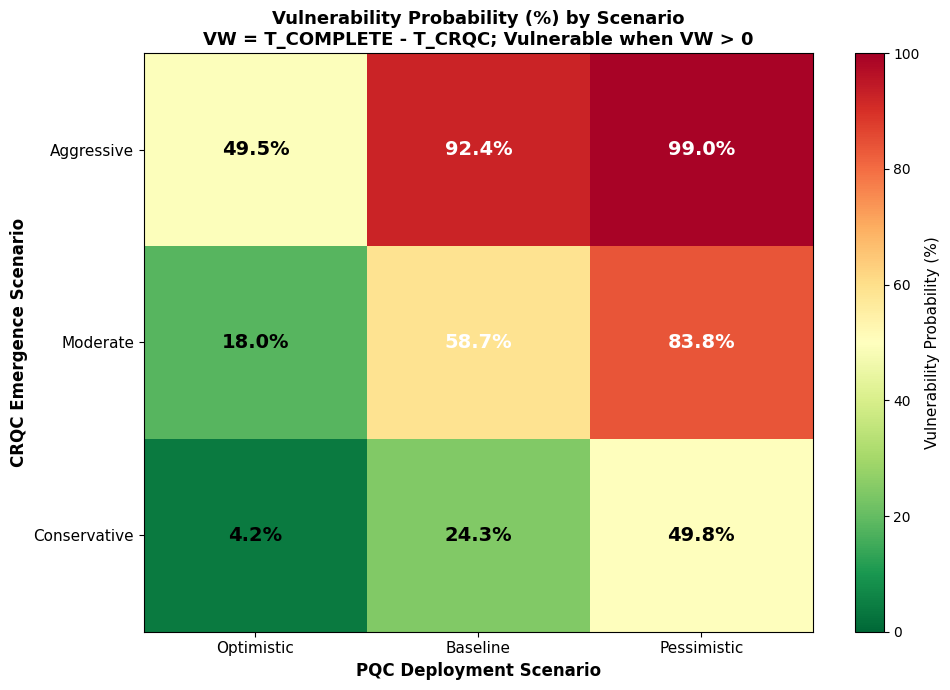

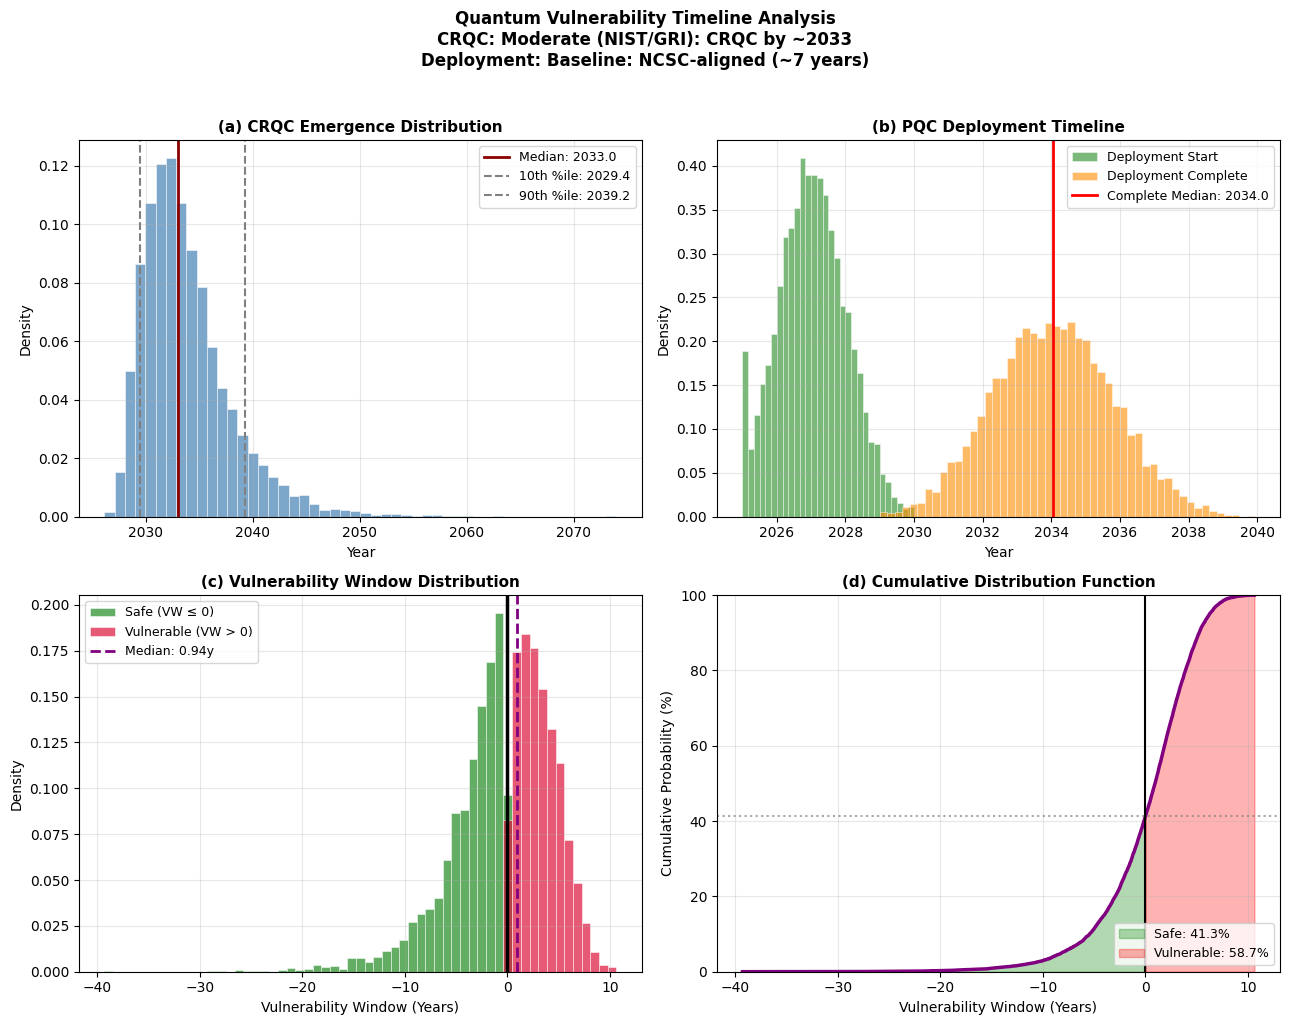

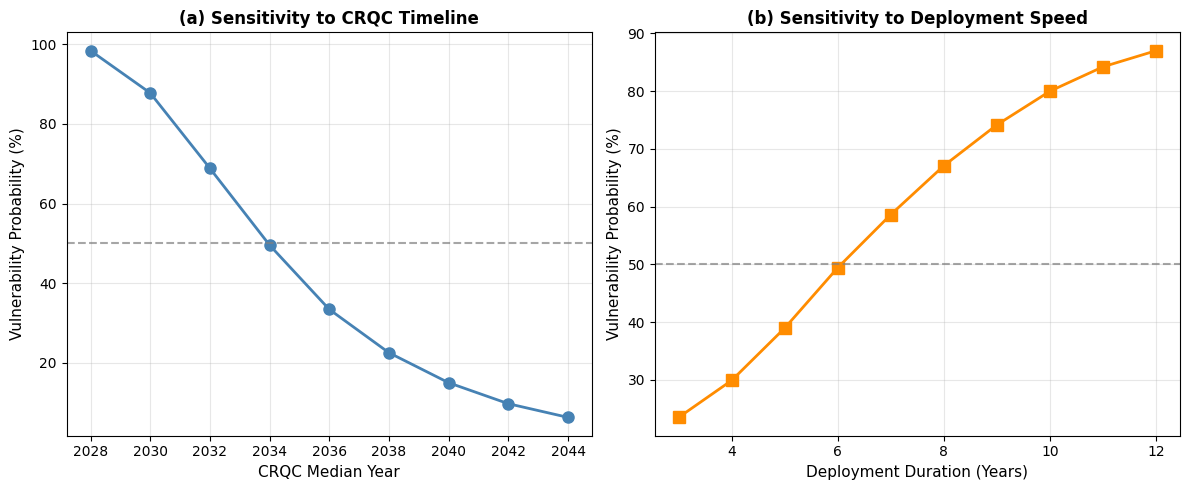

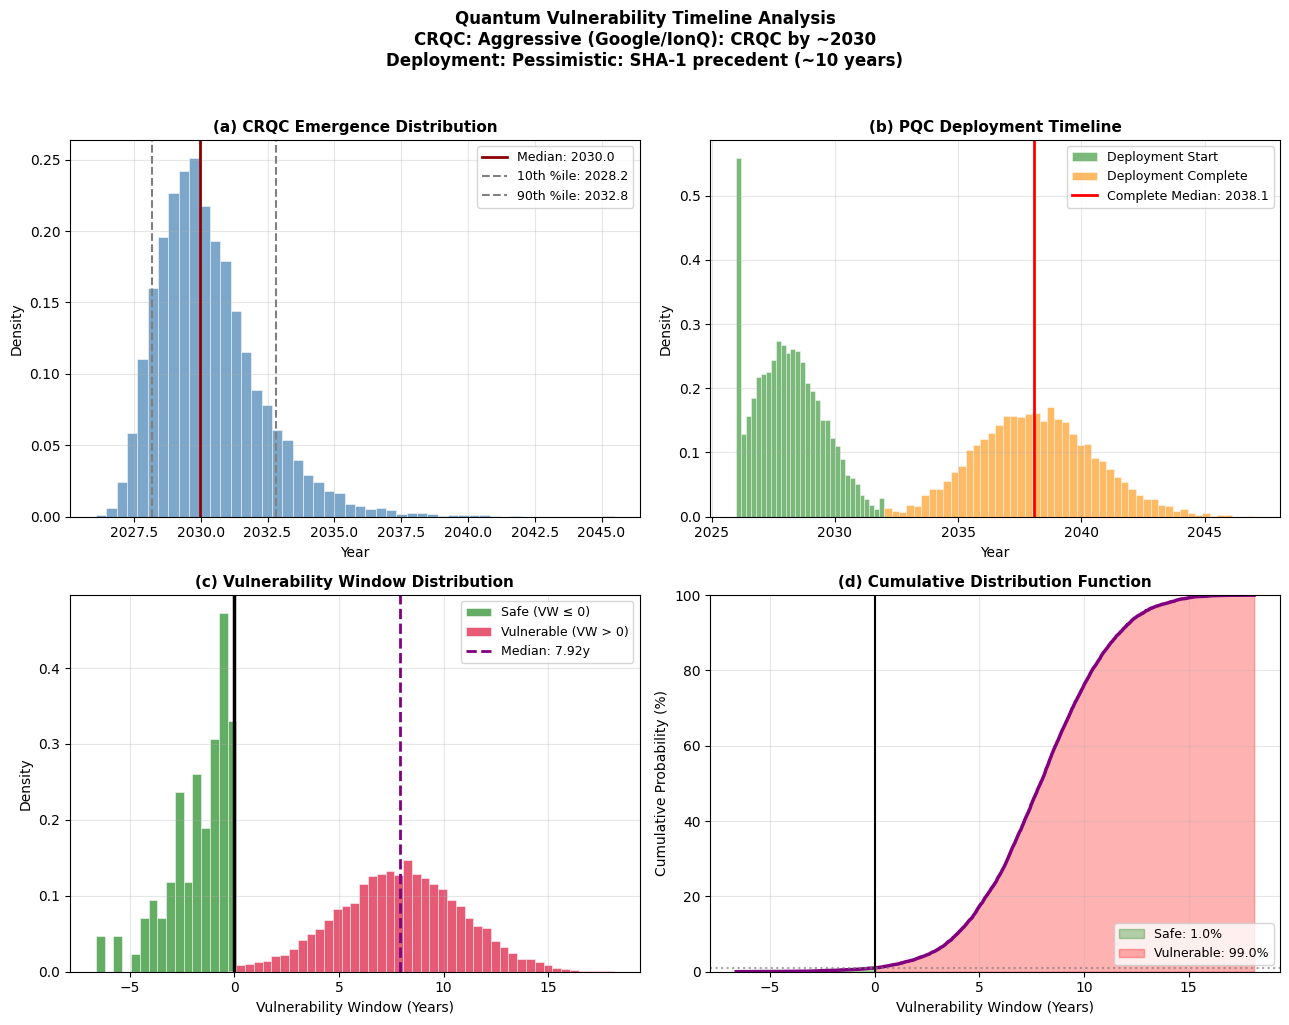

In [1]:
#!/usr/bin/env python3
"""
Quantum Vulnerability Window Monte Carlo Simulation
Research-Grounded Implementation

This module implements a Monte Carlo simulation to quantify the probability
that social media platforms will remain cryptographically vulnerable when
Cryptographically Relevant Quantum Computers (CRQC) emerge.

CORE FORMULA:
    Vulnerability Window (VW) = T_COMPLETE - T_CRQC
    
    Where:
    - T_CRQC: Year when CRQC can break current public-key cryptography
    - T_COMPLETE: Year when platform completes PQC deployment
    
    Interpretation:
    - VW > 0: Platform remains vulnerable after CRQC arrives
    - VW ≤ 0: Platform achieves quantum resistance before CRQC

PARAMETER DERIVATION:
    All parameters are derived from peer-reviewed research, expert surveys,
    government guidance, and industry roadmaps. See detailed citations below.

Author: Jack Pierrelouis, D.Sc.
Date: 2024
License: MIT
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Tuple, Dict, Optional, List
from enum import Enum
import warnings

# =============================================================================
# RESEARCH-GROUNDED PARAMETER DERIVATION
# =============================================================================

"""
CRQC EMERGENCE TIMELINE - LITERATURE REVIEW
============================================

Source 1: Global Risk Institute Quantum Threat Timeline Survey (2023-2024)
- Survey of 37+ quantum computing and cryptography experts
- Findings: 
  * 5 years (2028): <1% probability (24/37 experts)
  * 10 years (2033): Mixed, ~20-30% assign >50% probability
  * 15-20 years (2038-2043): Majority assign >50% probability
  * Median "tipping point": Between 15-20 years from 2023 = 2038-2043
  
Source 2: NIST Post-Quantum Cryptography Timeline (IR 8547, 2024)
- Sets 2035 as target completion date for federal PQC migration
- Implies expectation that CRQC could emerge by mid-2030s
- Quote: "complete migration by 2035 to ensure data remains secure"

Source 3: Expert Consensus Analysis (Multiple Sources)
- Mosca's Theorem: If X+Y > Z, start now (X=shelf-life, Y=migration, Z=threat)
- Google prediction: "sufficiently powerful quantum computers may be here by 2030"
- IonQ roadmap (2025): Claims CRQC capability by 2028 (aggressive outlier)
- Conservative estimates: 2040+ (National Academies, 2019)

Source 4: Technical Requirements Analysis
- Gidney & Ekerå (2021): ~20 million physical qubits to break RSA-2048
- Current state (2024): ~1,000 physical qubits
- Required error rates: 10^-12 for practical cryptanalysis
- Qubit doubling assumption: ~annual (similar to Moore's Law)

DERIVED CRQC DISTRIBUTION:
- Shape: Log-normal (right-skewed; technology breakthroughs are uncertain)
- Aggressive: median 2030, 90th percentile 2035 (IonQ/Google-aligned)
- Moderate: median 2033, 90th percentile 2040 (NIST/GRI-aligned)  
- Conservative: median 2038, 90th percentile 2048 (National Academies)
"""

"""
PQC DEPLOYMENT TIMELINE - LITERATURE REVIEW
============================================

Source 1: UK NCSC Migration Timelines (March 2025)
- Three phases:
  * By 2028: Discovery + planning complete
  * By 2031: High-priority migrations complete
  * By 2035: Full migration complete
- Acknowledges: "less commonly used technologies may face greater challenges"

Source 2: US Federal Requirements
- NSM-10 (2022): Federal systems quantum-safe by 2035
- NIST IR 8547: Deprecate 112-bit security by 2030
- Estimated cost: $7.1 billion for federal migration

Source 3: EU Roadmap (June 2025)
- Critical infrastructure protected by 2030
- Begin implementation by end-2026

Source 4: Industry Status (2024-2025)
- Meta: "Multi-year effort" for internal traffic only (started 2024)
- Google: Internal communications on PQC since 2022
- Most platforms: Discovery/planning phase
- Social media specific challenges:
  * Legacy infrastructure (10+ years old)
  * Mobile app ecosystem dependencies
  * Third-party integrations
  * User base scale (billions of users)

Source 5: Historical Precedent - TLS 1.3 Adoption
- Standardized: August 2018
- 15 months post-standard: ~20% of connections
- 5 years post-standard: ~95% of major sites
- Key difference: TLS 1.3 had no active threat; PQC migration more complex

DERIVED DEPLOYMENT DISTRIBUTION:
Social media platforms face unique challenges:
1. Massive scale (billions of users)
2. Complex mobile app ecosystems  
3. Legacy infrastructure dependencies
4. Third-party service integrations

Optimistic: TLS 1.3-like adoption (3-5 years) with strong incentives
Baseline: UK NCSC timeline (7-10 years from standards to completion)
Pessimistic: SHA-1 deprecation pattern (10-15 years despite known risks)
"""


# =============================================================================
# Configuration Classes
# =============================================================================

@dataclass
class CRQCParameters:
    """
    CRQC emergence distribution parameters.
    
    Uses log-normal distribution to model technology emergence uncertainty.
    Log-normal is appropriate because:
    - Emergence cannot occur before a minimum year (bounded at 0)
    - High uncertainty with right skew (breakthroughs unpredictable)
    - Multiplicative factors in development timelines
    
    Parameters are defined in terms of base_year + years_to_emergence.
    """
    base_year: float = 2025.0
    mu: float = 2.08  # ln(8) ≈ 2.08, giving median ~8 years
    sigma: float = 0.45
    description: str = ""
    
    @property
    def median_year(self) -> float:
        """Calculate median emergence year."""
        return self.base_year + np.exp(self.mu)
    
    @property
    def percentile_90_year(self) -> float:
        """Calculate 90th percentile emergence year."""
        return self.base_year + np.exp(self.mu + 1.282 * self.sigma)


@dataclass  
class DeploymentParameters:
    """
    PQC deployment timeline parameters.
    
    Models two components:
    1. Start time: When platform begins serious PQC deployment
    2. Duration: How long deployment takes to complete
    
    Both use truncated normal distributions with reasonable bounds.
    """
    # When deployment starts (year)
    start_mu: float = 2027.0
    start_sigma: float = 1.0
    start_min: float = 2025.0
    start_max: float = 2030.0
    
    # How long deployment takes (years)
    duration_mu: float = 6.0
    duration_sigma: float = 1.5
    duration_min: float = 3.0
    duration_max: float = 12.0
    
    description: str = ""
    
    @property
    def median_complete(self) -> float:
        """Estimate median completion year."""
        return self.start_mu + self.duration_mu


# Pre-defined scenarios based on research
CRQC_SCENARIOS = {
    "aggressive": CRQCParameters(
        base_year=2025.0,
        mu=np.log(5),      # Median: 2030
        sigma=0.35,
        description="Aggressive (Google/IonQ): CRQC by ~2030"
    ),
    "moderate": CRQCParameters(
        base_year=2025.0,
        mu=np.log(8),      # Median: 2033
        sigma=0.45,
        description="Moderate (NIST/GRI): CRQC by ~2033"
    ),
    "conservative": CRQCParameters(
        base_year=2025.0,
        mu=np.log(13),     # Median: 2038
        sigma=0.50,
        description="Conservative (Nat'l Academies): CRQC by ~2038"
    ),
}

DEPLOYMENT_SCENARIOS = {
    "optimistic": DeploymentParameters(
        start_mu=2026.0,
        start_sigma=0.75,
        start_min=2025.0,
        start_max=2028.0,
        duration_mu=4.0,
        duration_sigma=1.0,
        duration_min=2.5,
        duration_max=6.0,
        description="Optimistic: Aggressive deployment (~4 years)"
    ),
    "baseline": DeploymentParameters(
        start_mu=2027.0,
        start_sigma=1.0,
        start_min=2025.0,
        start_max=2030.0,
        duration_mu=7.0,
        duration_sigma=1.5,
        duration_min=4.0,
        duration_max=10.0,
        description="Baseline: NCSC-aligned (~7 years)"
    ),
    "pessimistic": DeploymentParameters(
        start_mu=2028.0,
        start_sigma=1.5,
        start_min=2026.0,
        start_max=2032.0,
        duration_mu=10.0,
        duration_sigma=2.0,
        duration_min=6.0,
        duration_max=15.0,
        description="Pessimistic: SHA-1 precedent (~10 years)"
    ),
}


# =============================================================================
# Simulation Engine
# =============================================================================

class QuantumVulnerabilitySimulation:
    """
    Monte Carlo simulation for quantum cryptographic vulnerability assessment.
    
    This simulation models the race between:
    1. CRQC emergence (T_CRQC): When quantum computers can break current crypto
    2. PQC completion (T_COMPLETE): When platforms finish quantum-safe migration
    
    A platform is vulnerable if T_COMPLETE > T_CRQC (completes after threat arrives).
    """
    
    def __init__(
        self,
        n_iterations: int = 10_000,
        random_seed: int = 42,
        crqc_params: CRQCParameters = None,
        deployment_params: DeploymentParameters = None,
    ):
        """
        Initialize simulation.
        
        Args:
            n_iterations: Number of Monte Carlo iterations.
            random_seed: Random seed for reproducibility.
            crqc_params: CRQC emergence distribution parameters.
            deployment_params: PQC deployment distribution parameters.
        """
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        self.crqc_params = crqc_params or CRQC_SCENARIOS["moderate"]
        self.deployment_params = deployment_params or DEPLOYMENT_SCENARIOS["baseline"]
        self.rng = np.random.default_rng(random_seed)
        self.results: Optional[pd.DataFrame] = None
        
    def _sample_crqc_emergence(self, n: int) -> np.ndarray:
        """
        Sample CRQC emergence times from log-normal distribution.
        
        The log-normal distribution models years from base_year to emergence.
        """
        p = self.crqc_params
        years_from_base = self.rng.lognormal(p.mu, p.sigma, n)
        return p.base_year + years_from_base
    
    def _sample_deployment_start(self, n: int) -> np.ndarray:
        """Sample deployment start times from truncated normal distribution."""
        p = self.deployment_params
        samples = self.rng.normal(p.start_mu, p.start_sigma, n)
        return np.clip(samples, p.start_min, p.start_max)
    
    def _sample_deployment_duration(self, n: int) -> np.ndarray:
        """Sample deployment durations from truncated normal distribution."""
        p = self.deployment_params
        samples = self.rng.normal(p.duration_mu, p.duration_sigma, n)
        return np.clip(samples, p.duration_min, p.duration_max)
    
    def run(self) -> pd.DataFrame:
        """
        Execute Monte Carlo simulation.
        
        Returns:
            DataFrame containing results for each iteration:
            - t_crqc: CRQC emergence year
            - t_start: PQC deployment start year
            - duration: PQC deployment duration
            - t_complete: PQC deployment completion year
            - vulnerability_window: VW = T_COMPLETE - T_CRQC
            - is_vulnerable: Boolean indicator (VW > 0)
        """
        n = self.n_iterations
        
        # Sample all temporal variables
        t_crqc = self._sample_crqc_emergence(n)
        t_start = self._sample_deployment_start(n)
        duration = self._sample_deployment_duration(n)
        t_complete = t_start + duration
        
        # Calculate vulnerability window
        # VW > 0 means deployment completes AFTER CRQC emerges = VULNERABLE
        vulnerability_window = t_complete - t_crqc
        is_vulnerable = vulnerability_window > 0
        
        self.results = pd.DataFrame({
            "t_crqc": t_crqc,
            "t_start": t_start,
            "duration": duration,
            "t_complete": t_complete,
            "vulnerability_window": vulnerability_window,
            "is_vulnerable": is_vulnerable,
        })
        
        return self.results
    
    def get_statistics(self) -> Dict[str, float]:
        """
        Calculate comprehensive summary statistics.
        
        Returns:
            Dictionary containing:
            - Vulnerability probability and counts
            - Vulnerability window statistics (all and vulnerable-only)
            - Timeline percentiles for CRQC and deployment
        """
        if self.results is None:
            raise ValueError("Run simulation first with run()")
        
        df = self.results
        vw = df["vulnerability_window"]
        vulnerable = df["is_vulnerable"]
        vw_vulnerable = vw[vulnerable]
        
        stats = {
            # Core vulnerability metrics
            "vulnerability_probability": vulnerable.mean(),
            "n_vulnerable": int(vulnerable.sum()),
            "n_safe": int((~vulnerable).sum()),
            
            # Vulnerability window - all iterations
            "vw_mean": vw.mean(),
            "vw_median": vw.median(),
            "vw_std": vw.std(),
            
            # Vulnerability window - vulnerable cases only
            "vw_vulnerable_mean": vw_vulnerable.mean() if len(vw_vulnerable) > 0 else np.nan,
            "vw_vulnerable_median": vw_vulnerable.median() if len(vw_vulnerable) > 0 else np.nan,
            
            # Percentiles
            "vw_p10": vw.quantile(0.10),
            "vw_p25": vw.quantile(0.25),
            "vw_p75": vw.quantile(0.75),
            "vw_p90": vw.quantile(0.90),
            "vw_p95": vw.quantile(0.95),
            
            # CRQC timeline
            "crqc_median": df["t_crqc"].median(),
            "crqc_mean": df["t_crqc"].mean(),
            "crqc_p10": df["t_crqc"].quantile(0.10),
            "crqc_p90": df["t_crqc"].quantile(0.90),
            
            # Deployment timeline
            "deploy_start_median": df["t_start"].median(),
            "deploy_duration_median": df["duration"].median(),
            "deploy_complete_median": df["t_complete"].median(),
            "deploy_complete_p10": df["t_complete"].quantile(0.10),
            "deploy_complete_p90": df["t_complete"].quantile(0.90),
        }
        
        return stats


# =============================================================================
# Analysis Functions
# =============================================================================

def run_scenario_matrix(
    n_iterations: int = 10_000,
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Run simulations across all CRQC × Deployment scenario combinations.
    
    Creates a 3×3 matrix of scenarios (9 total simulations).
    """
    results = []
    
    for crqc_name, crqc_params in CRQC_SCENARIOS.items():
        for deploy_name, deploy_params in DEPLOYMENT_SCENARIOS.items():
            sim = QuantumVulnerabilitySimulation(
                n_iterations=n_iterations,
                random_seed=random_seed,
                crqc_params=crqc_params,
                deployment_params=deploy_params,
            )
            sim.run()
            stats = sim.get_statistics()
            
            results.append({
                "crqc_scenario": crqc_name,
                "deployment_scenario": deploy_name,
                "crqc_description": crqc_params.description,
                "deploy_description": deploy_params.description,
                "vulnerability_probability": stats["vulnerability_probability"],
                "vw_median_vulnerable": stats["vw_vulnerable_median"],
                "vw_median_all": stats["vw_median"],
                "crqc_median": stats["crqc_median"],
                "deploy_complete_median": stats["deploy_complete_median"],
            })
    
    return pd.DataFrame(results)


def run_sensitivity_analysis(
    base_crqc: str = "moderate",
    base_deploy: str = "baseline",
    n_iterations: int = 10_000,
    random_seed: int = 42
) -> Dict[str, pd.DataFrame]:
    """
    Perform sensitivity analysis on key parameters.
    
    Varies one parameter at a time while holding others at baseline.
    """
    results = {}
    
    # Sensitivity to CRQC median
    crqc_medians = range(2028, 2045, 2)
    crqc_results = []
    for median_year in crqc_medians:
        years_from_base = median_year - 2025
        mu = np.log(years_from_base)
        
        params = CRQCParameters(mu=mu, sigma=0.45)
        sim = QuantumVulnerabilitySimulation(
            n_iterations=n_iterations,
            random_seed=random_seed,
            crqc_params=params,
            deployment_params=DEPLOYMENT_SCENARIOS[base_deploy],
        )
        sim.run()
        stats = sim.get_statistics()
        
        crqc_results.append({
            "crqc_median": median_year,
            "vulnerability_probability": stats["vulnerability_probability"],
            "vw_median": stats["vw_median"],
        })
    
    results["crqc_sensitivity"] = pd.DataFrame(crqc_results)
    
    # Sensitivity to deployment duration
    durations = range(3, 13, 1)
    duration_results = []
    for dur in durations:
        params = DeploymentParameters(duration_mu=dur, duration_sigma=1.5)
        sim = QuantumVulnerabilitySimulation(
            n_iterations=n_iterations,
            random_seed=random_seed,
            crqc_params=CRQC_SCENARIOS[base_crqc],
            deployment_params=params,
        )
        sim.run()
        stats = sim.get_statistics()
        
        duration_results.append({
            "deployment_duration": dur,
            "vulnerability_probability": stats["vulnerability_probability"],
            "vw_median": stats["vw_median"],
        })
    
    results["duration_sensitivity"] = pd.DataFrame(duration_results)
    
    return results


# =============================================================================
# Visualization Functions
# =============================================================================

def plot_scenario_matrix(
    matrix_df: pd.DataFrame,
    save_path: Optional[str] = None
) -> plt.Figure:
    """Create heatmap visualization of scenario matrix results."""
    # Pivot for heatmap
    pivot = matrix_df.pivot(
        index="crqc_scenario",
        columns="deployment_scenario",
        values="vulnerability_probability"
    ) * 100
    
    # Reorder for intuitive display
    crqc_order = ["aggressive", "moderate", "conservative"]
    deploy_order = ["optimistic", "baseline", "pessimistic"]
    pivot = pivot.reindex(index=crqc_order, columns=deploy_order)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    im = ax.imshow(pivot.values, cmap="RdYlGn_r", aspect="auto", vmin=0, vmax=100)
    
    # Labels
    ax.set_xticks(range(len(deploy_order)))
    ax.set_xticklabels([d.title() for d in deploy_order], fontsize=11)
    ax.set_yticks(range(len(crqc_order)))
    ax.set_yticklabels([c.title() for c in crqc_order], fontsize=11)
    
    ax.set_xlabel("PQC Deployment Scenario", fontsize=12, fontweight="bold")
    ax.set_ylabel("CRQC Emergence Scenario", fontsize=12, fontweight="bold")
    ax.set_title(
        "Vulnerability Probability (%) by Scenario\n"
        "VW = T_COMPLETE - T_CRQC; Vulnerable when VW > 0",
        fontsize=13, fontweight="bold"
    )
    
    # Add text annotations
    for i, crqc in enumerate(crqc_order):
        for j, deploy in enumerate(deploy_order):
            val = pivot.loc[crqc, deploy]
            color = "white" if val > 50 else "black"
            ax.text(j, i, f"{val:.1f}%", ha="center", va="center",
                   color=color, fontsize=14, fontweight="bold")
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Vulnerability Probability (%)", fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    return fig


def plot_timeline_distributions(
    sim: QuantumVulnerabilitySimulation,
    save_path: Optional[str] = None
) -> plt.Figure:
    """Create four-panel timeline distribution visualization."""
    if sim.results is None:
        raise ValueError("Run simulation first")
    
    df = sim.results
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    
    # Panel titles with scenario info
    crqc_desc = sim.crqc_params.description
    deploy_desc = sim.deployment_params.description
    
    fig.suptitle(
        f"Quantum Vulnerability Timeline Analysis\n"
        f"CRQC: {crqc_desc}\nDeployment: {deploy_desc}",
        fontsize=12, fontweight="bold", y=1.02
    )
    
    # (a) CRQC Emergence Distribution
    ax = axes[0, 0]
    ax.hist(df["t_crqc"], bins=50, density=True, alpha=0.7,
            color="steelblue", edgecolor="white", linewidth=0.5)
    median = df["t_crqc"].median()
    p10 = df["t_crqc"].quantile(0.10)
    p90 = df["t_crqc"].quantile(0.90)
    ax.axvline(median, color="darkred", linestyle="-", lw=2,
               label=f"Median: {median:.1f}")
    ax.axvline(p10, color="gray", linestyle="--", lw=1.5,
               label=f"10th %ile: {p10:.1f}")
    ax.axvline(p90, color="gray", linestyle="--", lw=1.5,
               label=f"90th %ile: {p90:.1f}")
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.set_title("(a) CRQC Emergence Distribution", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # (b) PQC Deployment Timeline
    ax = axes[0, 1]
    ax.hist(df["t_start"], bins=30, density=True, alpha=0.6,
            color="forestgreen", edgecolor="white", linewidth=0.5,
            label="Deployment Start")
    ax.hist(df["t_complete"], bins=50, density=True, alpha=0.6,
            color="darkorange", edgecolor="white", linewidth=0.5,
            label="Deployment Complete")
    ax.axvline(df["t_complete"].median(), color="red", linestyle="-", lw=2,
               label=f"Complete Median: {df['t_complete'].median():.1f}")
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.set_title("(b) PQC Deployment Timeline", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # (c) Vulnerability Window Distribution
    ax = axes[1, 0]
    vw = df["vulnerability_window"]
    
    # Color-code histogram
    safe_vw = vw[vw <= 0]
    vuln_vw = vw[vw > 0]
    
    bins = np.linspace(vw.min(), vw.max(), 60)
    ax.hist(safe_vw, bins=bins, density=True, alpha=0.7,
            color="forestgreen", edgecolor="white", linewidth=0.5,
            label="Safe (VW ≤ 0)")
    ax.hist(vuln_vw, bins=bins, density=True, alpha=0.7,
            color="crimson", edgecolor="white", linewidth=0.5,
            label="Vulnerable (VW > 0)")
    
    ax.axvline(0, color="black", lw=2.5, linestyle="-")
    ax.axvline(vw.median(), color="purple", linestyle="--", lw=2,
               label=f"Median: {vw.median():.2f}y")
    
    ax.set_xlabel("Vulnerability Window (Years)", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.set_title("(c) Vulnerability Window Distribution", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # (d) Cumulative Risk Curve
    ax = axes[1, 1]
    sorted_vw = np.sort(vw)
    cumulative = np.arange(1, len(sorted_vw) + 1) / len(sorted_vw) * 100
    
    ax.plot(sorted_vw, cumulative, color="purple", lw=2.5)
    ax.axvline(0, color="black", lw=1.5, linestyle="-")
    
    vuln_prob = df["is_vulnerable"].mean() * 100
    safe_prob = 100 - vuln_prob
    
    # Shade regions
    ax.fill_between(sorted_vw[sorted_vw <= 0],
                    cumulative[sorted_vw <= 0],
                    alpha=0.3, color="green", label=f"Safe: {safe_prob:.1f}%")
    ax.fill_between(sorted_vw[sorted_vw > 0],
                    cumulative[sorted_vw > 0],
                    alpha=0.3, color="red", label=f"Vulnerable: {vuln_prob:.1f}%")
    
    ax.axhline(safe_prob, color="gray", linestyle=":", alpha=0.7)
    
    ax.set_xlabel("Vulnerability Window (Years)", fontsize=10)
    ax.set_ylabel("Cumulative Probability (%)", fontsize=10)
    ax.set_title("(d) Cumulative Distribution Function", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9, loc="lower right")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    return fig


def plot_sensitivity_analysis(
    sensitivity_results: Dict[str, pd.DataFrame],
    save_path: Optional[str] = None
) -> plt.Figure:
    """Visualize sensitivity analysis results."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # CRQC sensitivity
    ax = axes[0]
    df = sensitivity_results["crqc_sensitivity"]
    ax.plot(df["crqc_median"], df["vulnerability_probability"] * 100,
            "o-", color="steelblue", lw=2, markersize=8)
    ax.set_xlabel("CRQC Median Year", fontsize=11)
    ax.set_ylabel("Vulnerability Probability (%)", fontsize=11)
    ax.set_title("(a) Sensitivity to CRQC Timeline", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.axhline(50, color="gray", linestyle="--", alpha=0.7)
    
    # Duration sensitivity
    ax = axes[1]
    df = sensitivity_results["duration_sensitivity"]
    ax.plot(df["deployment_duration"], df["vulnerability_probability"] * 100,
            "s-", color="darkorange", lw=2, markersize=8)
    ax.set_xlabel("Deployment Duration (Years)", fontsize=11)
    ax.set_ylabel("Vulnerability Probability (%)", fontsize=11)
    ax.set_title("(b) Sensitivity to Deployment Speed", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.axhline(50, color="gray", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    return fig


# =============================================================================
# Report Generation
# =============================================================================

def generate_comprehensive_report(
    matrix_df: pd.DataFrame,
    baseline_stats: Dict[str, float]
) -> str:
    """Generate comprehensive research report."""
    
    report = """
================================================================================
QUANTUM VULNERABILITY WINDOW MONTE CARLO SIMULATION
Research-Grounded Analysis Report
================================================================================

EXECUTIVE SUMMARY
-----------------
This analysis quantifies the probability that social media platforms will remain
cryptographically vulnerable when Cryptographically Relevant Quantum Computers
(CRQC) emerge. Using Monte Carlo simulation with parameters derived from expert
surveys, government guidance, and industry roadmaps, we model the race between
quantum threat emergence and post-quantum cryptography (PQC) deployment.

METHODOLOGY
-----------
Formula: Vulnerability Window (VW) = T_COMPLETE - T_CRQC

Where:
  T_CRQC    = Year when quantum computers can break current encryption
  T_COMPLETE = Year when platform completes PQC migration

Interpretation:
  VW > 0  →  Platform completes AFTER CRQC arrives  →  VULNERABLE
  VW ≤ 0  →  Platform completes BEFORE CRQC arrives →  SAFE

This formulation is intuitive:
  ✓ Faster deployment → earlier T_COMPLETE → lower vulnerability
  ✓ Earlier CRQC → higher vulnerability
  ✓ Later CRQC → more time to deploy → lower vulnerability

PARAMETER SOURCES
-----------------
CRQC Timeline:
  - Global Risk Institute Expert Survey (2023-2024): 37+ experts
  - NIST IR 8547 (2024): Federal migration target by 2035
  - Google/IonQ roadmaps: Aggressive estimates ~2030
  - National Academies (2019): Conservative estimate ~2038-2040

Deployment Timeline:
  - UK NCSC Guidance (March 2025): 2028/2031/2035 milestones
  - US NSM-10 (2022): Federal completion by 2035
  - TLS 1.3 precedent: ~5 years for widespread adoption
  - Meta/Google PQC status: Multi-year internal migration in progress

"""
    
    # Add matrix results
    report += """
SCENARIO MATRIX RESULTS
-----------------------
Vulnerability Probability (%) by Scenario Combination:

"""
    
    # Format matrix
    report += f"{'CRQC Scenario':<15} {'Optimistic':>12} {'Baseline':>12} {'Pessimistic':>12}\n"
    report += "-" * 55 + "\n"
    
    for crqc in ["aggressive", "moderate", "conservative"]:
        row = matrix_df[matrix_df["crqc_scenario"] == crqc]
        opt = row[row["deployment_scenario"] == "optimistic"]["vulnerability_probability"].values[0] * 100
        base = row[row["deployment_scenario"] == "baseline"]["vulnerability_probability"].values[0] * 100
        pess = row[row["deployment_scenario"] == "pessimistic"]["vulnerability_probability"].values[0] * 100
        
        report += f"{crqc.title():<15} {opt:>11.1f}% {base:>11.1f}% {pess:>11.1f}%\n"
    
    report += "-" * 55 + "\n"
    
    # Key findings
    baseline_row = matrix_df[
        (matrix_df["crqc_scenario"] == "moderate") &
        (matrix_df["deployment_scenario"] == "baseline")
    ].iloc[0]
    
    worst_row = matrix_df.loc[matrix_df["vulnerability_probability"].idxmax()]
    best_row = matrix_df.loc[matrix_df["vulnerability_probability"].idxmin()]
    
    report += f"""
KEY FINDINGS
------------
Baseline Scenario (Moderate CRQC + Baseline Deployment):
  Vulnerability Probability: {baseline_row['vulnerability_probability']*100:.1f}%
  CRQC Median: {baseline_row['crqc_median']:.0f}
  Deployment Complete Median: {baseline_row['deploy_complete_median']:.0f}
  Median VW (vulnerable only): {baseline_row['vw_median_vulnerable']:.1f} years

Worst Case ({worst_row['crqc_scenario'].title()} CRQC + {worst_row['deployment_scenario'].title()} Deployment):
  Vulnerability Probability: {worst_row['vulnerability_probability']*100:.1f}%

Best Case ({best_row['crqc_scenario'].title()} CRQC + {best_row['deployment_scenario'].title()} Deployment):
  Vulnerability Probability: {best_row['vulnerability_probability']*100:.1f}%

BASELINE SCENARIO DETAILED STATISTICS
-------------------------------------
"""
    
    for key, val in baseline_stats.items():
        if isinstance(val, float):
            report += f"  {key}: {val:.3f}\n"
        else:
            report += f"  {key}: {val}\n"
    
    report += """
IMPLICATIONS
------------
1. Under consensus assumptions (moderate CRQC ~2033, baseline deployment ~7 years),
   approximately {:.0f}% of social media platforms face vulnerability windows.

2. Deployment speed is critical: Moving from pessimistic to optimistic deployment
   reduces vulnerability by {:.0f} percentage points.

3. CRQC timeline uncertainty dominates: If aggressive estimates are correct (~2030),
   even optimistic deployment scenarios yield {:.0f}% vulnerability.

4. The "Harvest Now, Decrypt Later" threat makes action urgent regardless of
   exact vulnerability probability—data harvested today remains at risk.

RECOMMENDATIONS
---------------
1. Platforms should target optimistic deployment timelines (≤5 years)
2. Prioritize end-to-end encryption and authentication systems
3. Implement hybrid PQC immediately for high-value data
4. Monitor quantum computing progress for timeline adjustments
5. Coordinate industry-wide standards adoption

================================================================================
""".format(
        baseline_row['vulnerability_probability'] * 100,
        (worst_row['vulnerability_probability'] - best_row['vulnerability_probability']) * 100,
        matrix_df[(matrix_df['crqc_scenario'] == 'aggressive') & 
                  (matrix_df['deployment_scenario'] == 'optimistic')]['vulnerability_probability'].values[0] * 100
    )
    
    return report


# =============================================================================
# Main Execution
# =============================================================================

def main():
    """Main entry point for simulation."""
    print("=" * 70)
    print("QUANTUM VULNERABILITY MONTE CARLO SIMULATION")
    print("Research-Grounded Implementation")
    print("=" * 70)
    
    # Configuration
    n_iterations = 10_000
    random_seed = 42
    
    # Run scenario matrix
    print("\n[1/4] Running scenario matrix (9 combinations)...")
    matrix_df = run_scenario_matrix(n_iterations, random_seed)
    
    # Run baseline detailed simulation
    print("[2/4] Running detailed baseline simulation...")
    baseline_sim = QuantumVulnerabilitySimulation(
        n_iterations=n_iterations,
        random_seed=random_seed,
        crqc_params=CRQC_SCENARIOS["moderate"],
        deployment_params=DEPLOYMENT_SCENARIOS["baseline"],
    )
    baseline_sim.run()
    baseline_stats = baseline_sim.get_statistics()
    
    # Run sensitivity analysis
    print("[3/4] Running sensitivity analysis...")
    sensitivity = run_sensitivity_analysis(n_iterations=n_iterations, random_seed=random_seed)
    
    # Generate report
    print("[4/4] Generating reports and visualizations...")
    report = generate_comprehensive_report(matrix_df, baseline_stats)
    print(report)
    
    # Save outputs
    matrix_df.to_csv("scenario_matrix_results.csv", index=False)
    print("Saved: scenario_matrix_results.csv")
    
    with open("simulation_report.txt", "w") as f:
        f.write(report)
    print("Saved: simulation_report.txt")
    
    # Generate visualizations
    plot_scenario_matrix(matrix_df, "figure_1_scenario_matrix.png")
    print("Saved: figure_1_scenario_matrix.png")
    
    plot_timeline_distributions(baseline_sim, "figure_2_baseline_distributions.png")
    print("Saved: figure_2_baseline_distributions.png")
    
    plot_sensitivity_analysis(sensitivity, "figure_3_sensitivity.png")
    print("Saved: figure_3_sensitivity.png")
    
    # Also plot worst case
    worst_sim = QuantumVulnerabilitySimulation(
        n_iterations=n_iterations,
        random_seed=random_seed,
        crqc_params=CRQC_SCENARIOS["aggressive"],
        deployment_params=DEPLOYMENT_SCENARIOS["pessimistic"],
    )
    worst_sim.run()
    plot_timeline_distributions(worst_sim, "figure_4_worst_case.png")
    print("Saved: figure_4_worst_case.png")
    
    print("\n" + "=" * 70)
    print("Simulation complete.")
    print("=" * 70)
    
    return matrix_df, baseline_stats, sensitivity


if __name__ == "__main__":
    results = main()